In [166]:
import numpy as np
import pandas as pd
import csv
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd

pd.set_option('display.max_columns', 50)

In [167]:
# 2-digit code indicating the Technology of Transmission used to offer broadband service. 
def tech_code_translator(x):
    # ADSL, Cable, Fiber, Fixed Wireless, Satellite, Other
    if x in ['10', '11', '12', '20', '30']:
        return 'ADSL'
    if x in ['40', '41', '42', '43']:
        return 'Cable'
    if x == '50':
        return 'Fiber'
    if x == '60':
        return 'Satellite'
    if x == '70':
        return 'Fixed Wireless'
    return 'Other'
#     if x == '10':
#         return 'Asymetrical xDSL'
#     if x == '11':
#         return 'ADSL2'
#     if x == '12':
#         return 'VDSL' 
#     if x == '20':
#         return 'Symetrical xDSL'
#     if x == '30':
#         return 'Other Copper Wireline'
#     if x == '40':
#         return 'Cable Modem'
#     if x == '41':
#         return 'Cable Modem-DOCSIS1,1.1,2.0'
#     if x == '42':
#         return 'Cable Modem-DOCSIS 3.0'
#     if x == '43': 
#         return 'Cable Modem-DOCSIS 3.1'
#     if x == '50':
#         return 'Optical Carrier/Fiber to the End User'
#     if x == '60':
#         return 'Satellite'
#     if x == '70':
#         return 'Terrestrial Fixed Wireless'
#     if x == '90': 
#         return 'Electric Power Line'
#     if x == '0':
#         return 'Other'
#     return 'NOT VALID'

In [168]:
fcc_data_filepath = 'data/Fixed_Broadband_Deployment_Data__Jun__2019_Status_V1.csv'

converters = {'tract': lambda x: str(x), 
              'block': lambda x: str(x),
              'Technology Code': lambda x: tech_code_translator(x)
             }

data_file = pd.read_csv(fcc_data_filepath, converters = converters, encoding = "ISO-8859-1")
data_file.head()

,Logical Record Number,Provider ID,FRN,Provider Name,DBA Name,Holding Company Name,Holding Company Number,Holding Company Final,State,Census Block FIPS Code,Technology Code,Consumer,Max Advertised Downstream Speed (mbps),Max Advertised Upstream Speed (mbps),Business,Max CIR Downstream Speed (mbps),Max CIR Upstream Speed (mbps),county_code,tract,block,boro
0,19376907,50820,4963088,"ViaSat, Inc.",Viasat Inc,"ViaSat, Inc.",290111,"ViaSat, Inc.",NY,360050001000001,Satellite,1,35.0,3.0,1,0.0,0.0,36005,000100,0001,bronx
1,19376908,50820,4963088,"ViaSat, Inc.",Viasat Inc,"ViaSat, Inc.",290111,"ViaSat, Inc.",NY,360050001000002,Satellite,1,35.0,3.0,1,0.0,0.0,36005,000100,0002,bronx
2,19376909,50820,4963088,"ViaSat, Inc.",Viasat Inc,"ViaSat, Inc.",290111,"ViaSat, Inc.",NY,360050001001000,Satellite,1,35.0,3.0,1,0.0,0.0,36005,000100,1000,bronx
3,59544342,52979,1568880,GCI Communication Corp.,GCI Communication Corp.,GCI Holdings LLC,130534,GCI Holdings LLC,NY,360050001001000,Satellite,0,0.0,0.0,1,0.0,0.0,36005,000100,1000,bronx
4,59881129,53153,12369286,"HNS License Sub, LLC",HughesNet,"Hughes Network Systems, LLC",130627,"Hughes Network Systems, LLC",NY,360050001001000,Satellite,1,25.0,3.0,1,0.0,0.0,36005,000100,1000,bronx


In [169]:
total_cb = len(data_file['Census Block FIPS Code'].unique())

cb_25Mbps = len(data_file[(data_file["Max Advertised Downstream Speed (mbps)"] >= 25)]['Census Block FIPS Code'].unique())
cb_1Gbps = len(data_file[(data_file["Max Advertised Downstream Speed (mbps)"] >= 1000)]['Census Block FIPS Code'].unique())

print("There are {} census blocks".format(total_cb))

print("Blocks with access to at least 25 Mbps: {0:.2%}".format(cb_25Mbps/total_cb))
print("Blocks with access to at least 01 Gbps: {0:.2%}".format(cb_1Gbps/total_cb))

There are 39148 census blocks
Blocks with access to at least 25 Mbps: 100.00%
Blocks with access to at least 01 Gbps: 30.17%


In [170]:
data_file[data_file['Census Block FIPS Code'] == 360610135001006]

tech_code_filter = ['Fiber']
nonZeroService = data_file[True 
#                    & (data_file['Census Block FIPS Code'] == 360610135001006) 
                     & (data_file['Technology Code'].isin(tech_code_filter)) 
                     & (data_file['Max Advertised Downstream Speed (mbps)'] > 0)
                  ][['Provider Name', 'Technology Code', 'Census Block FIPS Code', 'boro']].drop_duplicates()[['Census Block FIPS Code', 'boro']]

blocksByProviders = nonZeroService.groupby(['Census Block FIPS Code', 'boro'], as_index=False).size().reset_index().rename(columns={0:'count'})

In [171]:
print("Distinct Providers for: ", tech_code_filter)
print("{0:.2%} of districts have any options".format(len(blocksByProviders)/total_cb))
for i in range(1, blocksByProviders['count'].max()+1):
    count = len(blocksByProviders[blocksByProviders['count'] == i])
    res = "{0:.2%}".format(count/total_cb)
    print("Blocks with {} distinct provider(s):".format(i), res)

Distinct Providers for:  ['Fiber']
76.67% of districts have any options
Blocks with 1 distinct provider(s): 73.96%
Blocks with 2 distinct provider(s): 2.60%
Blocks with 3 distinct provider(s): 0.11%
Blocks with 4 distinct provider(s): 0.00%


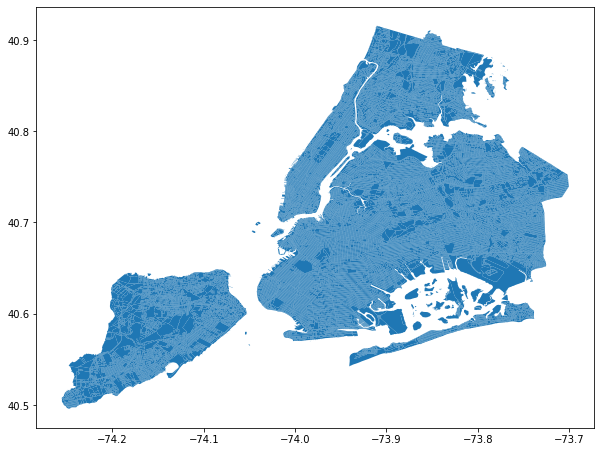

In [160]:
nyc_gpd = gpd.read_file("data/2010_Census_Blocks/geo_export_7829e0ad-0816-4dbe-b8a1-d10343209019.shp")
nyc_gpd.plot(figsize=(10,10))